In [166]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
from BlackScholes import *

import random
import pandas as pd
import math
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
import statsmodels.api as sm
import statsmodels.stats.diagnostic as tds
from statsmodels.api import add_constant
from scipy import stats
from scipy import optimize


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
r = 0.01  # risk-free rate
S= 100      # Underlying spot
sigma = 0.4 # implied volatility
T = 0.2     # Time to maturity

In [315]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, S, x, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, S, x, r, T, sigma, 0)[0]
#call_delta = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[1]
#put_delta = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[1]

In [5]:
import tensorflow as tf

In [316]:
# define the call and put prices using the BS model
call = lambda x,y: bsformula(1, S, x, r, T, y, 0)[0]
put = lambda x,y: bsformula(-1, S, x, r, T, y, 0)[0]

In [324]:
lb = 0.01           # lower bound on domain
ub = 200             # upper bound on domain
training_number = 100  # Number of training samples
testing_number = 100 # Number of testing samples
S = 100
eps=1.0/(100*100)

train_x_1 = np.array(np.linspace(lb,ub, training_number), dtype='float32').reshape(training_number, 1)
train_x_2 =[]
train_y = []
for K in train_x_1:
    sigma = 0.01+0.8*eps*(K-S)**2
    if (K>S):
      train_x_2.append(put(K,sigma))
    else:
      train_x_2.append(call(K,sigma))  
    train_y.append(sigma)
    
test_x_1 = np.array(np.linspace(lb,1.2*ub, testing_number), dtype='float32').reshape(testing_number, 1)
test_x_2 =[]
test_y = []
for K in test_x_1:
    sigma = 0.01+0.8*eps*(K-S)**2
    if (K>S):
      test_x_2.append(put(K,0.01+eps*(K-S)**2))
    else:
      test_x_2.append(call(K,0.01+0.8*eps*(K-S)**2)) 
    test_y.append(sigma)

In [389]:
np.max(S/test_x_1)

10000.0

In [293]:
#df_call['sigma']=sigma

In [346]:
train_x=np.array([0]*training_number*2, dtype='float32').reshape(training_number,2)

train_x[:,0]=np.transpose(np.array(train_x_1))
train_x[:,1]=np.transpose(np.array(train_x_2))

In [347]:
test_x=np.array([0]*testing_number*2, dtype='float32').reshape(testing_number,2)

test_x[:,0]=np.transpose(np.array(test_x_1))
test_x[:,1]=np.transpose(np.array(test_x_2))

# NN Implied Vol Calibration

In [358]:
n_hidden = 100 # 
initializer=tf.initializers.random_uniform(0, 1) # max_vol/n_hidden
#initializer = tf.initializers.RandomUniform(-1, 1)
#config = initializer.get_config()
#initializer = RandomUniform.from_config(config)


In [372]:

# see https://keras.io/constraints/
def NN1_model(n_hidden_units=n_hidden, l1_reg=0.0):    
    model = Sequential()
    model.add(Dense(n_hidden_units, input_dim=1, kernel_initializer='normal', activation='softplus'))
    #model.add(Dense(n_hidden_neurons, input_dim=1, kernel_initializer='normal',kernel_regularizer=l1(l1_reg), activation='relu'))
    model.add(Dense(1, input_dim=n_hidden_units, kernel_initializer=initializer, kernel_constraint = non_neg(), bias_constraint=non_neg()))  #use_bias=False))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    return model

print("\nUsing Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22\n")
lm = KerasRegressor(build_fn=NN1_model,epochs=2500, batch_size=1, verbose=1)  # This line defines a NN predictive model


Using Neural Networks, hidden neurons=1, l1_reg=0, epochs=40, batch_size=22



In [373]:
#lm.fit(np.asarray(x_train, dtype='float32'),np.asarray(y_train, dtype='float32'))
lm.fit(train_x[:,0],np.array(train_y))

Epoch 1/2500
100/100 [==============================] - 1s 6ms/step - loss: 4730.8718 - mean_absolute_error: 57.0971 - mean_squared_error: 4730.8718
Epoch 2/2500
100/100 [==============================] - 0s 995us/step - loss: 352.8854 - mean_absolute_error: 17.9769 - mean_squared_error: 352.8854
Epoch 3/2500
100/100 [==============================] - 0s 1ms/step - loss: 144.7651 - mean_absolute_error: 11.0271 - mean_squared_error: 144.7651
Epoch 4/2500
100/100 [==============================] - 0s 1ms/step - loss: 99.1532 - mean_absolute_error: 8.3754 - mean_squared_error: 99.1532
Epoch 5/2500
100/100 [==============================] - 0s 972us/step - loss: 78.8631 - mean_absolute_error: 6.9289 - mean_squared_error: 78.8631
Epoch 6/2500
100/100 [==============================] - 0s 977us/step - loss: 66.6935 - mean_absolute_error: 5.9842 - mean_squared_error: 66.6935
Epoch 7/2500
100/100 [==============================] - 0s 1ms/step - loss: 58.2658 - mean_absolute_error: 5.3427 - mea

100/100 [==============================] - 0s 1ms/step - loss: 2.3326 - mean_absolute_error: 0.7669 - mean_squared_error: 2.3326
Epoch 58/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2171 - mean_absolute_error: 0.7464 - mean_squared_error: 2.2171
Epoch 59/2500
100/100 [==============================] - 0s 958us/step - loss: 2.1033 - mean_absolute_error: 0.7244 - mean_squared_error: 2.1033
Epoch 60/2500
100/100 [==============================] - 0s 929us/step - loss: 1.9863 - mean_absolute_error: 0.6917 - mean_squared_error: 1.9863
Epoch 61/2500
100/100 [==============================] - 0s 930us/step - loss: 1.8850 - mean_absolute_error: 0.6683 - mean_squared_error: 1.8850
Epoch 62/2500
100/100 [==============================] - 0s 961us/step - loss: 1.7860 - mean_absolute_error: 0.6544 - mean_squared_error: 1.7860
Epoch 63/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.6928 - mean_absolute_error: 0.6346 - mean_squared_error: 1.6928
Epoch

100/100 [==============================] - 0s 1ms/step - loss: 0.1085 - mean_absolute_error: 0.1915 - mean_squared_error: 0.1085
Epoch 114/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.1026 - mean_absolute_error: 0.1851 - mean_squared_error: 0.1026
Epoch 115/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0983 - mean_absolute_error: 0.1855 - mean_squared_error: 0.0983
Epoch 116/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0933 - mean_absolute_error: 0.1821 - mean_squared_error: 0.0933
Epoch 117/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0874 - mean_absolute_error: 0.1735 - mean_squared_error: 0.0874
Epoch 118/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0853 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0853
Epoch 119/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0817 - mean_absolute_error: 0.1778 - mean_squared_error: 0.0817
Epoch 1

Epoch 170/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0163 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0163
Epoch 171/2500
100/100 [==============================] - 0s 959us/step - loss: 0.0153 - mean_absolute_error: 0.1065 - mean_squared_error: 0.0153
Epoch 172/2500
100/100 [==============================] - 0s 908us/step - loss: 0.0171 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0171
Epoch 173/2500
100/100 [==============================] - 0s 946us/step - loss: 0.0158 - mean_absolute_error: 0.1034 - mean_squared_error: 0.0158
Epoch 174/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1120 - mean_squared_error: 0.0177
Epoch 175/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0150 - mean_absolute_error: 0.1060 - mean_squared_error: 0.0150
Epoch 176/2500
100/100 [==============================] - 0s 962us/step - loss: 0.0138 - mean_absolute_error: 0.0996 - mean_square

100/100 [==============================] - 0s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0803 - mean_squared_error: 0.0095
Epoch 227/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0108 - mean_absolute_error: 0.0838 - mean_squared_error: 0.0108
Epoch 228/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0112 - mean_absolute_error: 0.0861 - mean_squared_error: 0.0112
Epoch 229/2500
100/100 [==============================] - 0s 936us/step - loss: 0.0097 - mean_absolute_error: 0.0797 - mean_squared_error: 0.0097
Epoch 230/2500
100/100 [==============================] - 0s 958us/step - loss: 0.0099 - mean_absolute_error: 0.0809 - mean_squared_error: 0.0099
Epoch 231/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0103 - mean_absolute_error: 0.0845 - mean_squared_error: 0.0103
Epoch 232/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0801 - mean_squared_error: 0.0089
Epo

100/100 [==============================] - 0s 960us/step - loss: 0.0073 - mean_absolute_error: 0.0733 - mean_squared_error: 0.0073
Epoch 283/2500
100/100 [==============================] - 0s 912us/step - loss: 0.0068 - mean_absolute_error: 0.0711 - mean_squared_error: 0.0068
Epoch 284/2500
100/100 [==============================] - 0s 921us/step - loss: 0.0067 - mean_absolute_error: 0.0709 - mean_squared_error: 0.0067
Epoch 285/2500
100/100 [==============================] - 0s 943us/step - loss: 0.0069 - mean_absolute_error: 0.0701 - mean_squared_error: 0.0069
Epoch 286/2500
100/100 [==============================] - 0s 920us/step - loss: 0.0067 - mean_absolute_error: 0.0703 - mean_squared_error: 0.0067
Epoch 287/2500
100/100 [==============================] - 0s 947us/step - loss: 0.0071 - mean_absolute_error: 0.0712 - mean_squared_error: 0.0071
Epoch 288/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0060 - mean_absolute_error: 0.0655 - mean_squared_error: 0.

100/100 [==============================] - 0s 962us/step - loss: 0.0053 - mean_absolute_error: 0.0609 - mean_squared_error: 0.0053
Epoch 339/2500
100/100 [==============================] - 0s 933us/step - loss: 0.0051 - mean_absolute_error: 0.0610 - mean_squared_error: 0.0051
Epoch 340/2500
100/100 [==============================] - 0s 926us/step - loss: 0.0055 - mean_absolute_error: 0.0649 - mean_squared_error: 0.0055
Epoch 341/2500
100/100 [==============================] - 0s 953us/step - loss: 0.0047 - mean_absolute_error: 0.0604 - mean_squared_error: 0.0047
Epoch 342/2500
100/100 [==============================] - 0s 946us/step - loss: 0.0068 - mean_absolute_error: 0.0673 - mean_squared_error: 0.0068
Epoch 343/2500
100/100 [==============================] - 0s 925us/step - loss: 0.0047 - mean_absolute_error: 0.0596 - mean_squared_error: 0.0047
Epoch 344/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0048 - mean_absolute_error: 0.0613 - mean_squared_error: 0.

100/100 [==============================] - 0s 950us/step - loss: 0.0039 - mean_absolute_error: 0.0539 - mean_squared_error: 0.0039
Epoch 395/2500
100/100 [==============================] - 0s 928us/step - loss: 0.0037 - mean_absolute_error: 0.0519 - mean_squared_error: 0.0037
Epoch 396/2500
100/100 [==============================] - 0s 909us/step - loss: 0.0046 - mean_absolute_error: 0.0573 - mean_squared_error: 0.0046
Epoch 397/2500
100/100 [==============================] - 0s 892us/step - loss: 0.0036 - mean_absolute_error: 0.0504 - mean_squared_error: 0.0036
Epoch 398/2500
100/100 [==============================] - 0s 940us/step - loss: 0.0040 - mean_absolute_error: 0.0558 - mean_squared_error: 0.0040
Epoch 399/2500
100/100 [==============================] - 0s 950us/step - loss: 0.0040 - mean_absolute_error: 0.0529 - mean_squared_error: 0.0040
Epoch 400/2500
100/100 [==============================] - 0s 952us/step - loss: 0.0044 - mean_absolute_error: 0.0567 - mean_squared_error: 

100/100 [==============================] - 0s 938us/step - loss: 0.0025 - mean_absolute_error: 0.0431 - mean_squared_error: 0.0025
Epoch 451/2500
100/100 [==============================] - 0s 910us/step - loss: 0.0028 - mean_absolute_error: 0.0456 - mean_squared_error: 0.0028
Epoch 452/2500
100/100 [==============================] - 0s 923us/step - loss: 0.0029 - mean_absolute_error: 0.0468 - mean_squared_error: 0.0029
Epoch 453/2500
100/100 [==============================] - 0s 922us/step - loss: 0.0030 - mean_absolute_error: 0.0458 - mean_squared_error: 0.0030
Epoch 454/2500
100/100 [==============================] - 0s 927us/step - loss: 0.0031 - mean_absolute_error: 0.0455 - mean_squared_error: 0.0031
Epoch 455/2500
100/100 [==============================] - 0s 915us/step - loss: 0.0030 - mean_absolute_error: 0.0473 - mean_squared_error: 0.0030
Epoch 456/2500
100/100 [==============================] - 0s 971us/step - loss: 0.0027 - mean_absolute_error: 0.0468 - mean_squared_error: 

100/100 [==============================] - 0s 908us/step - loss: 0.0028 - mean_absolute_error: 0.0454 - mean_squared_error: 0.0028
Epoch 507/2500
100/100 [==============================] - 0s 931us/step - loss: 0.0029 - mean_absolute_error: 0.0447 - mean_squared_error: 0.0029
Epoch 508/2500
100/100 [==============================] - 0s 908us/step - loss: 0.0021 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0021
Epoch 509/2500
100/100 [==============================] - 0s 931us/step - loss: 0.0020 - mean_absolute_error: 0.0383 - mean_squared_error: 0.0020
Epoch 510/2500
100/100 [==============================] - 0s 908us/step - loss: 0.0019 - mean_absolute_error: 0.0373 - mean_squared_error: 0.0019
Epoch 511/2500
100/100 [==============================] - 0s 953us/step - loss: 0.0020 - mean_absolute_error: 0.0391 - mean_squared_error: 0.0020
Epoch 512/2500
100/100 [==============================] - 0s 947us/step - loss: 0.0019 - mean_absolute_error: 0.0381 - mean_squared_error: 

100/100 [==============================] - 0s 906us/step - loss: 0.0015 - mean_absolute_error: 0.0333 - mean_squared_error: 0.0015
Epoch 563/2500
100/100 [==============================] - 0s 913us/step - loss: 0.0024 - mean_absolute_error: 0.0419 - mean_squared_error: 0.0024
Epoch 564/2500
100/100 [==============================] - 0s 933us/step - loss: 0.0016 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0016
Epoch 565/2500
100/100 [==============================] - 0s 923us/step - loss: 0.0015 - mean_absolute_error: 0.0339 - mean_squared_error: 0.0015
Epoch 566/2500
100/100 [==============================] - 0s 936us/step - loss: 0.0018 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0018
Epoch 567/2500
100/100 [==============================] - 0s 921us/step - loss: 0.0016 - mean_absolute_error: 0.0343 - mean_squared_error: 0.0016
Epoch 568/2500
100/100 [==============================] - 0s 959us/step - loss: 0.0016 - mean_absolute_error: 0.0351 - mean_squared_error: 

100/100 [==============================] - 0s 929us/step - loss: 0.0011 - mean_absolute_error: 0.0273 - mean_squared_error: 0.0011
Epoch 619/2500
100/100 [==============================] - 0s 916us/step - loss: 0.0013 - mean_absolute_error: 0.0313 - mean_squared_error: 0.0013
Epoch 620/2500
100/100 [==============================] - 0s 928us/step - loss: 0.0016 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0016
Epoch 621/2500
100/100 [==============================] - 0s 920us/step - loss: 0.0014 - mean_absolute_error: 0.0308 - mean_squared_error: 0.0014
Epoch 622/2500
100/100 [==============================] - 0s 920us/step - loss: 0.0017 - mean_absolute_error: 0.0346 - mean_squared_error: 0.0017
Epoch 623/2500
100/100 [==============================] - 0s 935us/step - loss: 0.0012 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0012
Epoch 624/2500
100/100 [==============================] - 0s 930us/step - loss: 0.0011 - mean_absolute_error: 0.0282 - mean_squared_error: 

100/100 [==============================] - 0s 922us/step - loss: 0.0013 - mean_absolute_error: 0.0297 - mean_squared_error: 0.0013
Epoch 674/2500
100/100 [==============================] - 0s 945us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_squared_error: 0.0017
Epoch 675/2500
100/100 [==============================] - 0s 934us/step - loss: 0.0019 - mean_absolute_error: 0.0379 - mean_squared_error: 0.0019
Epoch 676/2500
100/100 [==============================] - 0s 919us/step - loss: 8.6841e-04 - mean_absolute_error: 0.0238 - mean_squared_error: 8.6841e-04
Epoch 677/2500
100/100 [==============================] - 0s 914us/step - loss: 9.2589e-04 - mean_absolute_error: 0.0253 - mean_squared_error: 9.2589e-04
Epoch 678/2500
100/100 [==============================] - 0s 939us/step - loss: 9.7045e-04 - mean_absolute_error: 0.0264 - mean_squared_error: 9.7045e-04
Epoch 679/2500
100/100 [==============================] - 0s 924us/step - loss: 9.8767e-04 - mean_absolute_error: 0

100/100 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_absolute_error: 0.0354 - mean_squared_error: 0.0022
Epoch 728/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_absolute_error: 0.0314 - mean_squared_error: 0.0019
Epoch 729/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.2332e-04 - mean_absolute_error: 0.0244 - mean_squared_error: 8.2332e-04
Epoch 730/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0286 - mean_squared_error: 0.0012  
Epoch 731/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.0010e-04 - mean_absolute_error: 0.0237 - mean_squared_error: 8.0010e-04
Epoch 732/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0010 - mean_absolute_error: 0.0268 - mean_squared_error: 0.0010    
Epoch 733/2500
100/100 [==============================] - 0s 2ms/step - loss: 8.2729e-04 - mean_absolute_error: 0.0240 - mean_squ

100/100 [==============================] - 0s 1ms/step - loss: 6.8649e-04 - mean_absolute_error: 0.0209 - mean_squared_error: 6.8649e-04
Epoch 782/2500
100/100 [==============================] - 0s 1ms/step - loss: 6.4594e-04 - mean_absolute_error: 0.0205 - mean_squared_error: 6.4594e-04
Epoch 783/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.1350e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 7.1350e-04
Epoch 784/2500
100/100 [==============================] - 0s 1ms/step - loss: 6.1278e-04 - mean_absolute_error: 0.0207 - mean_squared_error: 6.1278e-04
Epoch 785/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.9756e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 5.9756e-04
Epoch 786/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.0842e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 7.0842e-04
Epoch 787/2500
100/100 [==============================] - 0s 1ms/step - loss: 6.4600e-04 - mean_absolut

100/100 [==============================] - 0s 1ms/step - loss: 5.2301e-04 - mean_absolute_error: 0.0182 - mean_squared_error: 5.2301e-04
Epoch 836/2500
100/100 [==============================] - 0s 988us/step - loss: 5.6579e-04 - mean_absolute_error: 0.0194 - mean_squared_error: 5.6579e-04
Epoch 837/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.2914e-04 - mean_absolute_error: 0.0179 - mean_squared_error: 5.2914e-04
Epoch 838/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.8410e-04 - mean_absolute_error: 0.0195 - mean_squared_error: 5.8410e-04
Epoch 839/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0023  
Epoch 840/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.2660e-04 - mean_absolute_error: 0.0245 - mean_squared_error: 8.2660e-04
Epoch 841/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.4018e-04 - mean_absolute_er

Epoch 889/2500
100/100 [==============================] - 0s 876us/step - loss: 4.6498e-04 - mean_absolute_error: 0.0175 - mean_squared_error: 4.6498e-04
Epoch 890/2500
100/100 [==============================] - 0s 916us/step - loss: 4.5464e-04 - mean_absolute_error: 0.0168 - mean_squared_error: 4.5464e-04
Epoch 891/2500
100/100 [==============================] - 0s 920us/step - loss: 6.1191e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 6.1191e-04
Epoch 892/2500
100/100 [==============================] - 0s 957us/step - loss: 0.0035 - mean_absolute_error: 0.0367 - mean_squared_error: 0.0035
Epoch 893/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.0128e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 7.0128e-04
Epoch 894/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.8701e-04 - mean_absolute_error: 0.0176 - mean_squared_error: 4.8701e-04
Epoch 895/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.6624e-04

100/100 [==============================] - 0s 2ms/step - loss: 4.8227e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 4.8227e-04
Epoch 944/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.9104e-04 - mean_absolute_error: 0.0154 - mean_squared_error: 3.9104e-04
Epoch 945/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.0541e-04 - mean_absolute_error: 0.0161 - mean_squared_error: 4.0541e-04
Epoch 946/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.6427e-04 - mean_absolute_error: 0.0153 - mean_squared_error: 3.6427e-04
Epoch 947/2500
100/100 [==============================] - 0s 1ms/step - loss: 6.0608e-04 - mean_absolute_error: 0.0211 - mean_squared_error: 6.0608e-04
Epoch 948/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.2322e-04 - mean_absolute_error: 0.0169 - mean_squared_error: 4.2322e-04
Epoch 949/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.0431e-04 - mean_absolut

100/100 [==============================] - 0s 2ms/step - loss: 5.2420e-04 - mean_absolute_error: 0.0184 - mean_squared_error: 5.2420e-04
Epoch 998/2500
100/100 [==============================] - 0s 2ms/step - loss: 3.1731e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 3.1731e-04
Epoch 999/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.5176e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 3.5176e-04
Epoch 1000/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.4090e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.4090e-04
Epoch 1001/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.1982e-04 - mean_absolute_error: 0.0173 - mean_squared_error: 4.1982e-04
Epoch 1002/2500
100/100 [==============================] - 0s 2ms/step - loss: 3.3245e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.3245e-04
Epoch 1003/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_absolut

100/100 [==============================] - 0s 1ms/step - loss: 2.9757e-04 - mean_absolute_error: 0.0141 - mean_squared_error: 2.9757e-04
Epoch 1051/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.9863e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 2.9863e-04
Epoch 1052/2500
100/100 [==============================] - 0s 918us/step - loss: 2.7912e-04 - mean_absolute_error: 0.0130 - mean_squared_error: 2.7912e-04
Epoch 1053/2500
100/100 [==============================] - 0s 969us/step - loss: 2.9602e-04 - mean_absolute_error: 0.0139 - mean_squared_error: 2.9602e-04
Epoch 1054/2500
100/100 [==============================] - 0s 990us/step - loss: 2.6142e-04 - mean_absolute_error: 0.0128 - mean_squared_error: 2.6142e-04
Epoch 1055/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.7524e-04 - mean_absolute_error: 0.0135 - mean_squared_error: 2.7524e-04
Epoch 1056/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.3555e-04 - 

100/100 [==============================] - 0s 948us/step - loss: 0.0016 - mean_absolute_error: 0.0255 - mean_squared_error: 0.0016  
Epoch 1104/2500
100/100 [==============================] - 0s 942us/step - loss: 6.8869e-04 - mean_absolute_error: 0.0208 - mean_squared_error: 6.8869e-04
Epoch 1105/2500
100/100 [==============================] - 0s 924us/step - loss: 2.9786e-04 - mean_absolute_error: 0.0144 - mean_squared_error: 2.9786e-04
Epoch 1106/2500
100/100 [==============================] - 0s 931us/step - loss: 2.1656e-04 - mean_absolute_error: 0.0119 - mean_squared_error: 2.1656e-04
Epoch 1107/2500
100/100 [==============================] - 0s 930us/step - loss: 2.8845e-04 - mean_absolute_error: 0.0141 - mean_squared_error: 2.8845e-04
Epoch 1108/2500
100/100 [==============================] - 0s 929us/step - loss: 2.6829e-04 - mean_absolute_error: 0.0129 - mean_squared_error: 2.6829e-04
Epoch 1109/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.7371e-04 - 

100/100 [==============================] - 0s 1ms/step - loss: 2.8604e-04 - mean_absolute_error: 0.0139 - mean_squared_error: 2.8604e-04
Epoch 1157/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.3533e-04 - mean_absolute_error: 0.0123 - mean_squared_error: 2.3533e-04
Epoch 1158/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.1715e-04 - mean_absolute_error: 0.0117 - mean_squared_error: 2.1715e-04
Epoch 1159/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.7011e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 2.7011e-04
Epoch 1160/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.0659e-04 - mean_absolute_error: 0.0141 - mean_squared_error: 3.0659e-04
Epoch 1161/2500
100/100 [==============================] - 0s 1ms/step - loss: 9.9237e-04 - mean_absolute_error: 0.0201 - mean_squared_error: 9.9237e-04
Epoch 1162/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_absol

100/100 [==============================] - 0s 912us/step - loss: 2.1695e-04 - mean_absolute_error: 0.0117 - mean_squared_error: 2.1695e-04
Epoch 1210/2500
100/100 [==============================] - 0s 946us/step - loss: 1.8053e-04 - mean_absolute_error: 0.0105 - mean_squared_error: 1.8053e-04
Epoch 1211/2500
100/100 [==============================] - 0s 937us/step - loss: 2.2486e-04 - mean_absolute_error: 0.0119 - mean_squared_error: 2.2486e-04
Epoch 1212/2500
100/100 [==============================] - 0s 914us/step - loss: 6.7306e-04 - mean_absolute_error: 0.0172 - mean_squared_error: 6.7306e-04
Epoch 1213/2500
100/100 [==============================] - 0s 918us/step - loss: 2.2937e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.2937e-04
Epoch 1214/2500
100/100 [==============================] - 0s 927us/step - loss: 2.0737e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.0737e-04
Epoch 1215/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0012 

100/100 [==============================] - 0s 943us/step - loss: 1.7002e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 1.7002e-04
Epoch 1263/2500
100/100 [==============================] - 0s 914us/step - loss: 1.9780e-04 - mean_absolute_error: 0.0116 - mean_squared_error: 1.9780e-04
Epoch 1264/2500
100/100 [==============================] - 0s 905us/step - loss: 1.9509e-04 - mean_absolute_error: 0.0110 - mean_squared_error: 1.9509e-04
Epoch 1265/2500
100/100 [==============================] - 0s 923us/step - loss: 2.5344e-04 - mean_absolute_error: 0.0129 - mean_squared_error: 2.5344e-04
Epoch 1266/2500
100/100 [==============================] - 0s 923us/step - loss: 3.0969e-04 - mean_absolute_error: 0.0140 - mean_squared_error: 3.0969e-04
Epoch 1267/2500
100/100 [==============================] - 0s 948us/step - loss: 4.2172e-04 - mean_absolute_error: 0.0144 - mean_squared_error: 4.2172e-04
Epoch 1268/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0011 

100/100 [==============================] - 0s 924us/step - loss: 1.9797e-04 - mean_absolute_error: 0.0115 - mean_squared_error: 1.9797e-04
Epoch 1316/2500
100/100 [==============================] - 0s 924us/step - loss: 2.2024e-04 - mean_absolute_error: 0.0121 - mean_squared_error: 2.2024e-04
Epoch 1317/2500
100/100 [==============================] - 0s 938us/step - loss: 4.6028e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 4.6028e-04
Epoch 1318/2500
100/100 [==============================] - 0s 924us/step - loss: 2.1512e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 2.1512e-04
Epoch 1319/2500
100/100 [==============================] - 0s 943us/step - loss: 3.9276e-04 - mean_absolute_error: 0.0148 - mean_squared_error: 3.9276e-04
Epoch 1320/2500
100/100 [==============================] - 0s 922us/step - loss: 2.2614e-04 - mean_absolute_error: 0.0123 - mean_squared_error: 2.2614e-04
Epoch 1321/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2949e

100/100 [==============================] - 0s 947us/step - loss: 2.1843e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.1843e-04
Epoch 1369/2500
100/100 [==============================] - 0s 908us/step - loss: 3.2095e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 3.2095e-04
Epoch 1370/2500
100/100 [==============================] - 0s 921us/step - loss: 2.6789e-04 - mean_absolute_error: 0.0122 - mean_squared_error: 2.6789e-04
Epoch 1371/2500
100/100 [==============================] - 0s 938us/step - loss: 3.1044e-04 - mean_absolute_error: 0.0132 - mean_squared_error: 3.1044e-04
Epoch 1372/2500
100/100 [==============================] - 0s 933us/step - loss: 2.6047e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.6047e-04
Epoch 1373/2500
100/100 [==============================] - 0s 939us/step - loss: 2.2255e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.2255e-04
Epoch 1374/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3930e

100/100 [==============================] - 0s 920us/step - loss: 3.9146e-04 - mean_absolute_error: 0.0137 - mean_squared_error: 3.9146e-04
Epoch 1422/2500
100/100 [==============================] - 0s 934us/step - loss: 1.8903e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 1.8903e-04
Epoch 1423/2500
100/100 [==============================] - 0s 927us/step - loss: 2.0368e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.0368e-04
Epoch 1424/2500
100/100 [==============================] - 0s 946us/step - loss: 1.7840e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 1.7840e-04
Epoch 1425/2500
100/100 [==============================] - 0s 933us/step - loss: 1.2139e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.2139e-04
Epoch 1426/2500
100/100 [==============================] - 0s 930us/step - loss: 1.6984e-04 - mean_absolute_error: 0.0095 - mean_squared_error: 1.6984e-04
Epoch 1427/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.0001e

100/100 [==============================] - 0s 940us/step - loss: 1.9619e-04 - mean_absolute_error: 0.0105 - mean_squared_error: 1.9619e-04
Epoch 1475/2500
100/100 [==============================] - 0s 877us/step - loss: 1.1717e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.1717e-04
Epoch 1476/2500
100/100 [==============================] - 0s 935us/step - loss: 3.5405e-04 - mean_absolute_error: 0.0140 - mean_squared_error: 3.5405e-04
Epoch 1477/2500
100/100 [==============================] - 0s 920us/step - loss: 4.4588e-04 - mean_absolute_error: 0.0158 - mean_squared_error: 4.4588e-04
Epoch 1478/2500
100/100 [==============================] - 0s 918us/step - loss: 7.7933e-04 - mean_absolute_error: 0.0177 - mean_squared_error: 7.7933e-04
Epoch 1479/2500
100/100 [==============================] - 0s 933us/step - loss: 2.7098e-04 - mean_absolute_error: 0.0122 - mean_squared_error: 2.7098e-04
Epoch 1480/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.7978e

100/100 [==============================] - 0s 921us/step - loss: 2.5910e-04 - mean_absolute_error: 0.0125 - mean_squared_error: 2.5910e-04
Epoch 1528/2500
100/100 [==============================] - 0s 940us/step - loss: 1.2913e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.2913e-04
Epoch 1529/2500
100/100 [==============================] - 0s 917us/step - loss: 2.1440e-04 - mean_absolute_error: 0.0111 - mean_squared_error: 2.1440e-04
Epoch 1530/2500
100/100 [==============================] - 0s 903us/step - loss: 1.2737e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.2737e-04
Epoch 1531/2500
100/100 [==============================] - 0s 932us/step - loss: 1.2302e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 1.2302e-04
Epoch 1532/2500
100/100 [==============================] - 0s 918us/step - loss: 1.3725e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.3725e-04
Epoch 1533/2500
100/100 [==============================] - 0s 981us/step - loss: 3.813

100/100 [==============================] - 0s 2ms/step - loss: 1.1087e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.1087e-04
Epoch 1581/2500
100/100 [==============================] - 0s 2ms/step - loss: 2.6541e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 2.6541e-04
Epoch 1582/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.2939e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.2939e-04
Epoch 1583/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.7757e-04 - mean_absolute_error: 0.0098 - mean_squared_error: 1.7757e-04
Epoch 1584/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.4006e-04 - mean_absolute_error: 0.0095 - mean_squared_error: 1.4006e-04
Epoch 1585/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.9248e-04 - mean_absolute_error: 0.0102 - mean_squared_error: 1.9248e-04
Epoch 1586/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.2338e-04 - mean_a

100/100 [==============================] - 0s 2ms/step - loss: 2.7567e-04 - mean_absolute_error: 0.0129 - mean_squared_error: 2.7567e-04
Epoch 1634/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.9901e-04 - mean_absolute_error: 0.0108 - mean_squared_error: 1.9901e-04
Epoch 1635/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.3281e-04 - mean_absolute_error: 0.0115 - mean_squared_error: 2.3281e-04
Epoch 1636/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.5293e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.5293e-04
Epoch 1637/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.8834e-04 - mean_absolute_error: 0.0126 - mean_squared_error: 2.8834e-04
Epoch 1638/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.5267e-04 - mean_absolute_error: 0.0096 - mean_squared_error: 1.5267e-04
Epoch 1639/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.6947e-04 - mean_a

100/100 [==============================] - 0s 1ms/step - loss: 1.6314e-04 - mean_absolute_error: 0.0096 - mean_squared_error: 1.6314e-04
Epoch 1687/2500
100/100 [==============================] - 0s 896us/step - loss: 5.7324e-04 - mean_absolute_error: 0.0140 - mean_squared_error: 5.7324e-04
Epoch 1688/2500
100/100 [==============================] - 0s 918us/step - loss: 2.0185e-04 - mean_absolute_error: 0.0110 - mean_squared_error: 2.0185e-04
Epoch 1689/2500
100/100 [==============================] - 0s 932us/step - loss: 2.8706e-04 - mean_absolute_error: 0.0112 - mean_squared_error: 2.8706e-04
Epoch 1690/2500
100/100 [==============================] - 0s 920us/step - loss: 2.6966e-04 - mean_absolute_error: 0.0095 - mean_squared_error: 2.6966e-04
Epoch 1691/2500
100/100 [==============================] - 0s 982us/step - loss: 1.2005e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.2005e-04
Epoch 1692/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.6966e-0

100/100 [==============================] - 0s 946us/step - loss: 0.0014 - mean_absolute_error: 0.0205 - mean_squared_error: 0.0014  
Epoch 1740/2500
100/100 [==============================] - 0s 917us/step - loss: 4.1730e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 4.1730e-04
Epoch 1741/2500
100/100 [==============================] - 0s 930us/step - loss: 1.2406e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.2406e-04
Epoch 1742/2500
100/100 [==============================] - 0s 938us/step - loss: 2.0646e-04 - mean_absolute_error: 0.0103 - mean_squared_error: 2.0646e-04
Epoch 1743/2500
100/100 [==============================] - 0s 922us/step - loss: 1.0330e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.0330e-04
Epoch 1744/2500
100/100 [==============================] - 0s 958us/step - loss: 1.9518e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 1.9518e-04
Epoch 1745/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.1446e-04 - 

100/100 [==============================] - 0s 950us/step - loss: 8.6960e-04 - mean_absolute_error: 0.0178 - mean_squared_error: 8.6960e-04
Epoch 1793/2500
100/100 [==============================] - 0s 951us/step - loss: 1.8123e-04 - mean_absolute_error: 0.0093 - mean_squared_error: 1.8123e-04
Epoch 1794/2500
100/100 [==============================] - 0s 877us/step - loss: 2.2506e-04 - mean_absolute_error: 0.0103 - mean_squared_error: 2.2506e-04
Epoch 1795/2500
100/100 [==============================] - 0s 926us/step - loss: 2.7119e-04 - mean_absolute_error: 0.0112 - mean_squared_error: 2.7119e-04
Epoch 1796/2500
100/100 [==============================] - 0s 927us/step - loss: 0.0029 - mean_absolute_error: 0.0312 - mean_squared_error: 0.0029
Epoch 1797/2500
100/100 [==============================] - 0s 939us/step - loss: 1.3117e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 1.3117e-04
Epoch 1798/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.5219e-04 - me

100/100 [==============================] - 0s 941us/step - loss: 1.2284e-04 - mean_absolute_error: 0.0090 - mean_squared_error: 1.2284e-04
Epoch 1846/2500
100/100 [==============================] - 0s 1ms/step - loss: 5.4869e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 5.4869e-04
Epoch 1847/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2712e-04 - mean_absolute_error: 0.0105 - mean_squared_error: 2.2712e-04
Epoch 1848/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3791e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.3791e-04
Epoch 1849/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.4490e-05 - mean_absolute_error: 0.0078 - mean_squared_error: 8.4490e-05
Epoch 1850/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.7752e-04 - mean_absolute_error: 0.0102 - mean_squared_error: 1.7752e-04
Epoch 1851/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2532e-04 - mean

100/100 [==============================] - 0s 967us/step - loss: 1.3918e-04 - mean_absolute_error: 0.0084 - mean_squared_error: 1.3918e-04
Epoch 1899/2500
100/100 [==============================] - 0s 931us/step - loss: 3.6491e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 3.6491e-04
Epoch 1900/2500
100/100 [==============================] - 0s 911us/step - loss: 1.9612e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 1.9612e-04
Epoch 1901/2500
100/100 [==============================] - 0s 939us/step - loss: 1.1396e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.1396e-04
Epoch 1902/2500
100/100 [==============================] - 0s 934us/step - loss: 1.5605e-04 - mean_absolute_error: 0.0100 - mean_squared_error: 1.5605e-04
Epoch 1903/2500
100/100 [==============================] - 0s 921us/step - loss: 1.7862e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 1.7862e-04
Epoch 1904/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.0745e

100/100 [==============================] - 0s 1ms/step - loss: 3.4920e-04 - mean_absolute_error: 0.0129 - mean_squared_error: 3.4920e-04
Epoch 1952/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2702e-04 - mean_absolute_error: 0.0108 - mean_squared_error: 2.2702e-04
Epoch 1953/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.2297e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 3.2297e-04
Epoch 1954/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.2763e-04 - mean_absolute_error: 0.0085 - mean_squared_error: 1.2763e-04
Epoch 1955/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.6203e-04 - mean_absolute_error: 0.0093 - mean_squared_error: 1.6203e-04
Epoch 1956/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.4143e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.4143e-04
Epoch 1957/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.4343e-05 - mean_a

100/100 [==============================] - 0s 2ms/step - loss: 1.2501e-04 - mean_absolute_error: 0.0090 - mean_squared_error: 1.2501e-04
Epoch 2005/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.4807e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.4807e-04
Epoch 2006/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.8920e-04 - mean_absolute_error: 0.0116 - mean_squared_error: 2.8920e-04
Epoch 2007/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.0703e-04 - mean_absolute_error: 0.0188 - mean_squared_error: 8.0703e-04
Epoch 2008/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.0371e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.0371e-04
Epoch 2009/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.7832e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 2.7832e-04
Epoch 2010/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.2904e-04 - mean_a

100/100 [==============================] - 0s 1ms/step - loss: 4.1105e-04 - mean_absolute_error: 0.0136 - mean_squared_error: 4.1105e-04
Epoch 2058/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.4837e-04 - mean_absolute_error: 0.0098 - mean_squared_error: 1.4837e-04
Epoch 2059/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.5641e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.5641e-04
Epoch 2060/2500
100/100 [==============================] - 0s 977us/step - loss: 2.3586e-04 - mean_absolute_error: 0.0110 - mean_squared_error: 2.3586e-04
Epoch 2061/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.8346e-04 - mean_absolute_error: 0.0137 - mean_squared_error: 3.8346e-04
Epoch 2062/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.7712e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.7712e-04
Epoch 2063/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.5212e-04 - mean

100/100 [==============================] - 0s 965us/step - loss: 9.7299e-05 - mean_absolute_error: 0.0079 - mean_squared_error: 9.7299e-05
Epoch 2111/2500
100/100 [==============================] - 0s 917us/step - loss: 1.2339e-04 - mean_absolute_error: 0.0090 - mean_squared_error: 1.2339e-04
Epoch 2112/2500
100/100 [==============================] - 0s 935us/step - loss: 2.3367e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.3367e-04
Epoch 2113/2500
100/100 [==============================] - 0s 912us/step - loss: 3.2995e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 3.2995e-04
Epoch 2114/2500
100/100 [==============================] - 0s 958us/step - loss: 7.6277e-04 - mean_absolute_error: 0.0159 - mean_squared_error: 7.6277e-04
Epoch 2115/2500
100/100 [==============================] - 0s 953us/step - loss: 1.3507e-04 - mean_absolute_error: 0.0095 - mean_squared_error: 1.3507e-04
Epoch 2116/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.9557e

100/100 [==============================] - 0s 977us/step - loss: 8.0538e-05 - mean_absolute_error: 0.0074 - mean_squared_error: 8.0538e-05
Epoch 2164/2500
100/100 [==============================] - 0s 950us/step - loss: 2.9615e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 2.9615e-04
Epoch 2165/2500
100/100 [==============================] - 0s 921us/step - loss: 1.3361e-04 - mean_absolute_error: 0.0093 - mean_squared_error: 1.3361e-04
Epoch 2166/2500
100/100 [==============================] - 0s 926us/step - loss: 1.5894e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.5894e-04
Epoch 2167/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.8154e-04 - mean_absolute_error: 0.0103 - mean_squared_error: 1.8154e-04
Epoch 2168/2500
100/100 [==============================] - 0s 986us/step - loss: 2.5781e-04 - mean_absolute_error: 0.0112 - mean_squared_error: 2.5781e-04
Epoch 2169/2500
100/100 [==============================] - 0s 932us/step - loss: 1.1307e

100/100 [==============================] - 0s 2ms/step - loss: 8.3691e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 8.3691e-05
Epoch 2217/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.4696e-04 - mean_absolute_error: 0.0086 - mean_squared_error: 1.4696e-04
Epoch 2218/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3519e-04 - mean_absolute_error: 0.0082 - mean_squared_error: 1.3519e-04
Epoch 2219/2500
100/100 [==============================] - 0s 1ms/step - loss: 9.4511e-05 - mean_absolute_error: 0.0074 - mean_squared_error: 9.4511e-05
Epoch 2220/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.1102e-04 - mean_absolute_error: 0.0076 - mean_squared_error: 1.1102e-04
Epoch 2221/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.3605e-04 - mean_absolute_error: 0.0107 - mean_squared_error: 2.3605e-04
Epoch 2222/2500
100/100 [==============================] - 0s 1ms/step - loss: 4.0701e-04 - mean_a

100/100 [==============================] - 0s 1ms/step - loss: 6.3509e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 6.3509e-04
Epoch 2270/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.2536e-04 - mean_absolute_error: 0.0135 - mean_squared_error: 3.2536e-04
Epoch 2271/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.2312e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.2312e-04
Epoch 2272/2500
100/100 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0015  
Epoch 2273/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.0479e-04 - mean_absolute_error: 0.0127 - mean_squared_error: 7.0479e-04
Epoch 2274/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.1161e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.1161e-04
Epoch 2275/2500
100/100 [==============================] - 0s 1ms/step - loss: 9.3913e-05 - mean_absolut

100/100 [==============================] - 0s 1ms/step - loss: 1.8377e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8377e-04
Epoch 2323/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.4413e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.4413e-04
Epoch 2324/2500
100/100 [==============================] - 0s 943us/step - loss: 1.7508e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.7508e-04
Epoch 2325/2500
100/100 [==============================] - 0s 957us/step - loss: 7.5470e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 7.5470e-05
Epoch 2326/2500
100/100 [==============================] - 0s 955us/step - loss: 1.6102e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.6102e-04
Epoch 2327/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.7506e-04 - mean_absolute_error: 0.0098 - mean_squared_error: 1.7506e-04
Epoch 2328/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.0160e-04 - 

100/100 [==============================] - 0s 2ms/step - loss: 1.0722e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.0722e-04
Epoch 2376/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2074e-04 - mean_absolute_error: 0.0107 - mean_squared_error: 2.2074e-04
Epoch 2377/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3631e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 1.3631e-04
Epoch 2378/2500
100/100 [==============================] - 0s 946us/step - loss: 2.6060e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.6060e-04
Epoch 2379/2500
100/100 [==============================] - 0s 1ms/step - loss: 9.3111e-05 - mean_absolute_error: 0.0072 - mean_squared_error: 9.3111e-05
Epoch 2380/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.8715e-04 - mean_absolute_error: 0.0125 - mean_squared_error: 3.8715e-04
Epoch 2381/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3928e-04 - mean

100/100 [==============================] - 0s 2ms/step - loss: 9.7688e-05 - mean_absolute_error: 0.0079 - mean_squared_error: 9.7688e-05
Epoch 2429/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.1924e-04 - mean_absolute_error: 0.0083 - mean_squared_error: 1.1924e-04
Epoch 2430/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.4385e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 7.4385e-05
Epoch 2431/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.2929e-04 - mean_absolute_error: 0.0106 - mean_squared_error: 2.2929e-04
Epoch 2432/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.0750e-04 - mean_absolute_error: 0.0078 - mean_squared_error: 1.0750e-04
Epoch 2433/2500
100/100 [==============================] - 0s 1ms/step - loss: 7.3643e-04 - mean_absolute_error: 0.0166 - mean_squared_error: 7.3643e-04
Epoch 2434/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3316e-04 - mean_a

100/100 [==============================] - 0s 2ms/step - loss: 5.7115e-04 - mean_absolute_error: 0.0141 - mean_squared_error: 5.7115e-04
Epoch 2482/2500
100/100 [==============================] - 0s 2ms/step - loss: 1.4833e-04 - mean_absolute_error: 0.0093 - mean_squared_error: 1.4833e-04
Epoch 2483/2500
100/100 [==============================] - 0s 1ms/step - loss: 3.5112e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 3.5112e-04
Epoch 2484/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.3737e-04 - mean_absolute_error: 0.0090 - mean_squared_error: 1.3737e-04
Epoch 2485/2500
100/100 [==============================] - 0s 1ms/step - loss: 1.6097e-04 - mean_absolute_error: 0.0093 - mean_squared_error: 1.6097e-04
Epoch 2486/2500
100/100 [==============================] - 0s 1ms/step - loss: 8.0672e-04 - mean_absolute_error: 0.0195 - mean_squared_error: 8.0672e-04
Epoch 2487/2500
100/100 [==============================] - 0s 1ms/step - loss: 2.1984e-04 - mean_a

In [374]:
W1=lm.model.get_weights()[0]
b1=lm.model.get_weights()[1]
W2=lm.model.get_weights()[2]
b2=lm.model.get_weights()[3]

In [375]:
y_pred= lm.predict(test_x[:,0])

100/100 [==============================] - 0s 2ms/step


Text(0,0.5,'$\\sigma$')

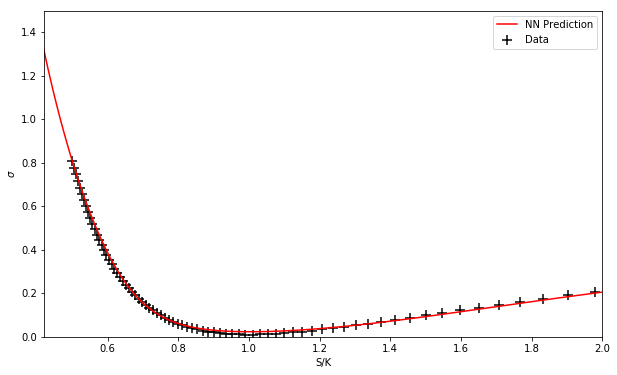

In [395]:
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
#plt.plot(test_x[:,0], np.array(test_y), color = 'black', label = 'Data')
plt.plot(S/test_x[:,0], np.array(y_pred), color = 'red', label = 'NN Prediction')
plt.scatter(S/train_x[:,0], np.array(train_y), color = 'black', marker = '+', s = 100, label = 'Data') 
#plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
#plt.xlim([KC/2.0,2.0*KC])
plt.xlim([0.42,2]) #lb+(ub-lb)*max(test_x_1)])

plt.ylim([0,1.5]) # lb+(ub-lb)*max(test_x_1)-KC])
plt.xlabel('S/K')
plt.ylabel('$\sigma$')

# observed option chain

In [225]:
df=pd.read_csv('SPX_08082013.csv')

#df_=df.dropna()

In [228]:
S = 1698.9
put_idx=np.where(df.Strike>=S)
call_idx=np.where(df.Strike<S)
#list(df.columns.values)

df_call=df[['Maturity','Strike','BID','ASK']].loc[call_idx]
df_put=df[['Maturity','Strike','BID.1','ASK.1']].loc[put_idx]

df_call['mid']=0.5*(df_call['BID'] + df_call['ASK'])

df_put['mid']=0.5*(df_put['BID.1'] + df_put['ASK.1'])

In [290]:
def calc_impl_vol(price = 5., CallPutFlag=1, underlying = 100., strike = 100., time = 1., rf = 0.01):
 
    #print(CallPutFlag,price, underlying, strike, time)
    #f = lambda x: BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price
    #print(bsformula(CallPutFlag, underlying, strike, rf, time, 0.0, 0)[0]-price)
    
    f = lambda x: bsformula(CallPutFlag, underlying, strike, rf, time, x, 0)[0]-price
 
    return optimize.brentq(f,-0.5,5.)

In [292]:
sigma= np.array([0]*len(df_call), dtype='float32')
for i in range(len(df_call)):
    sigma[i]=calc_impl_vol(df_call.mid.iloc[i], 1, S, df_call.Strike.iloc[i], df_call.Maturity.iloc[i]/252,0.001)
    print(sigma[i])
    #df_['Impl Vol'].iloc[i]=sigma

1.5938111e-12
6.0869853e-13
1.7261584e-14
4.9388136e-13
1.0394277e-12
1.1432429e-12
1.0315978e-13
5.102311e-13
1.0164187e-12
4.2040622e-13
1.3569566e-12
9.760648e-13
1.7933958e-13
6.3281536e-13
1.1958985e-12
6.742607e-13
2.747109e-13
1.1924255e-12
6.802407e-13
2.1490486e-13
2.0215985e-13
8.483251e-13
6.612172e-13
8.417086e-13
4.048791e-13
3.6860567e-13
6.856682e-13
8.728672e-13
7.7253416e-13
1.5165481e-13
1.8794658e-13
7.9041407e-13
3.476568e-14
5.0623427e-13
4.5502214e-13
9.673745e-13
1.2504403e-14
8.071476e-13
8.7257165e-13
9.468807e-13
5.420247e-13
1.5281371e-12
5.343077e-13
3.0108736e-13
1.30867e-12
3.6502027e-13
7.000038e-13
7.890892e-13
5.8246935e-13
6.138878e-13
8.232341e-13
6.2152036e-13
2.0612524e-13
4.0751056e-13
2.9410683e-13
5.8714616e-13
1.7843206e-12
8.191294e-13
1.0529119e-12
5.930593e-13
2.5114999e-13
9.438086e-13
7.884806e-13
0.111029185
0.09099486
0.10593294
0.09444094
0.09371429
1.3512052e-12
7.3690145e-14
6.504539e-14
1.6855194e-13
1.0368875e-12
2.374196e-13
9.29487

1.415533e-12
4.7649916e-13
1.0956715e-13
2.0336176e-13
3.9137416e-13
7.602713e-13
2.4226218e-13
4.387422e-13
5.9187254e-14
1.2456157e-12
2.2542004e-13
7.859089e-13
7.773472e-13
6.4469795e-13
4.6229296e-13
4.963594e-13
4.3259824e-13
8.190558e-13
6.1611583e-13
1.6038628e-14
2.24439e-13
2.9443199e-13
9.805221e-13
4.4062106e-13
7.622429e-13
2.9384213e-13
6.68426e-13
4.6344374e-13
8.779261e-13
1.6238194e-12
1.0059233e-12
1.105994e-12
7.037858e-13
6.6717237e-13
8.8794586e-13
8.3216734e-13
1.0110337e-12
1.0618247e-13
8.5206045e-13
1.2275116e-12
1.0695283e-12
6.4209873e-13
9.03363e-13
4.250815e-13
6.9174045e-13
3.788582e-13
9.029839e-13
4.9831016e-13
5.8301275e-13
8.2531264e-13
1.41948e-12
1.9485326e-17
3.341755e-14
2.8001055e-13
5.504187e-13
9.968066e-13
6.19689e-13
5.376967e-14
6.8064646e-13
1.0076313e-12
6.1443195e-13
1.6165175e-13
3.1637486e-13
1.93792e-13
1.7092688e-13
5.993055e-13
9.390627e-13
5.002732e-13
3.2906073e-13
1.6415673e-12
2.4361437e-13
3.493704e-13
9.970979e-13
1.152917e-12
5

# old

In [142]:
X = df_itm

X=X.drop(columns=['Underlying','Impl Vol', 'LAST'], axis=1)
Y =df_itm

In [143]:
Y=Y.drop(columns=['Underlying','Maturity','Strike','LAST'])

In [144]:
max_vol=np.max(Y)

In [145]:
x_train, x_test= train_test_split(np.asarray(X), test_size=0.2)
y_train, y_test = train_test_split(np.asarray(Y), test_size=0.2)

In [ ]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(test_x[idx,1], test_y[idx], color = 'red', label = 'NN Prediction')
plt.plot(lb+(ub-lb)*test_x_1.flatten(), call_delta(np.array(test_x_1)), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x_1, call_delta(np.array(train_x_1)), color = 'black', marker = '+', s = 100) 
#plt.fill_between(lb+(ub-lb)*test_x_1.flatten(), (y_pred_1.T-2*sigma_1).flatten(), (y_pred_1.T+2*sigma_1).flatten(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
#plt.xlim([KC/2.0,2.0*KC])
plt.xlim([KC/2.0,350]) #lb+(ub-lb)*max(test_x_1)])

plt.ylim([0,1.2]) # lb+(ub-lb)*max(test_x_1)-KC])
plt.xlabel('S')
plt.ylabel('$\Delta$')